In [77]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from keras.models import load_model
import tensorflow.keras.backend as K
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras
import os
from data_generation import *
from batch_creator import *
from gp_kernels import *
from gp_priors import *
from gp_plots import *

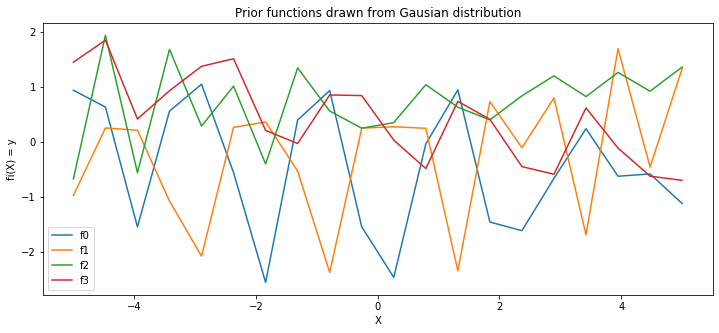

In [78]:
plot_gp_prior(4, n=20)

In [79]:
def create_batch_gp_mim_2(pos, tar, batch_s=128):
    '''
    '''
    shape = tar.shape[0]
    batch_idx_tr = np.random.choice(list(range(shape)), batch_s)
    batch_tar_tr = tar[batch_idx_tr, :]
    batch_pos_tr = pos[batch_idx_tr, :]
    return batch_tar_tr, batch_pos_tr, batch_idx_tr

In [447]:
def data_generator_for_gp_mimick_gpt(num_obs, kernel, tr_percent=0.8):
    '''



    '''
    obs_per_sample = np.random.randint(20, 60, size = num_obs)
    df = np.zeros((num_obs * 2, np.max(obs_per_sample)))
    for i in range(0, num_obs * 2, 2):
        x = np.random.uniform(-5, 5, size=(1, obs_per_sample[int(i / 2)]))
        k = kernel(x)
        f_prior = generate_priors(k, obs_per_sample[int(i / 2)], 1)

        df[i, :x.shape[1]] = x
        df[i + 1, :x.shape[1]] = f_prior

    rows = df.shape[0]
    cols = df.shape[1]
    tr_rows = int(tr_percent * rows)
    tr_rows = tr_rows if tr_rows % 2 == 0 else tr_rows + 1
    df_tr = df[:tr_rows, :]
    df_te = df[tr_rows:, :]

    pad_pos_tr = df_tr[::2, :]
    pad_pos_te = df_te[::2, :]
    pad_y_fren_tr = df_tr[1::2, :]
    pad_y_fren_te = df_te[1::2, :]

    return pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te

In [448]:
def create_padding_mask(seq):
    '''
    
    
    '''
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention.
    return seq[:, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [449]:
def create_look_ahead_mask(size):
    '''
    
    
    '''
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    print(tf.shape(mask))
    return mask  # (seq_len, seq_len)

In [450]:
def create_masks(position, tar):
    '''
    -------------------
    Parameters: 
    position :
    tar :
    -------------------
    Returns: 
    combined_mask_pos :
    combined_mask_tar :
    '''
    
    pos_padding_mask = create_padding_mask(position)
    tar_padding_mask = create_padding_mask(tar)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    look_ahead_mask_pos = create_look_ahead_mask(tf.shape(position)[1])
    # if max seq length is 40 -- > this will be 40X40 
    ## this will be batch_size X 1 X 40
    
    ## This will also be (64, 40, 40)
    combined_mask_pos = tf.maximum(pos_padding_mask, look_ahead_mask_pos)
    combined_mask_tar = tf.maximum(tar_padding_mask, look_ahead_mask)
    
    
    return combined_mask_pos, combined_mask_tar

In [585]:
def two_d_softmax(logits, ax):
    '''
    
    '''
    softmax = tf.divide(tf.exp(logits), tf.reduce_sum(tf.exp(logits), axis=ax))
    return softmax

In [586]:
a, b = create_masks(batch_pos_tr, batch_tar_tr[:, :-1])

tf.Tensor([58 58], shape=(2,), dtype=int32)
tf.Tensor([59 59], shape=(2,), dtype=int32)


In [587]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te = data_generator_for_gp_mimick_gpt(10000, rbf_kernel)

In [588]:
loss_object = tf.keras.losses.MeanSquaredError(reduction='none')
optimizer = tf.keras.optimizers.Adam()

In [589]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [590]:
# Since the target sequences are padded, 
# it is important to apply a padding mask when calculating the loss.

In [591]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [592]:
def dot_product_attention(q, k, v, mask, pos_mask):
    '''
    
    '''
    # similarity 
    # q = k = v  shape := (batch_size, max_seq_len - 1, max_seq_len -1)
    matmul_qk = tf.matmul(q, k, transpose_a = True)
    matmul_vv = tf.matmul(v, v, transpose_a = True)
    matmul_vv = matmul_vv[:, tf.newaxis, :, :]
    nl_qk = tf.nn.relu(matmul_qk) 
    nl_qk = nl_qk[:, tf.newaxis, :, :]
    print('nl_qk: ', nl_qk)
    # matmul_qk shape := (batch_size, max_seq_len - 1, max_seq_len - 1)

    # -1e9 will turn the softmax output in this locations to zero
    # this is a good mask as an input for softmax -- we need also masking when 
    # want to use matmul as is 
    if mask is not None:
        matmul_qk += (mask * -1e9)
    
    
    print('pos_mask:', pos_mask)
    if pos_mask is not None:
        nl_qk *= (1 - pos_mask)
        matmul_vv *= (1 - pos_mask)
        
    print('nl_qk: ', nl_qk)
    print('matmul_vv: ', matmul_vv)
#     print('matmul_qk after mask: ', matmul_qk)
#     shape=(128, 58, 58)
        
     # turn simialrity to scores
    # !!! need to insert here 2d softmax
    attention_weights = tf.nn.softmax(tf.reshape(nl_qk, [tf.shape(nl_qk)[0], tf.shape(nl_qk)[1], -1]), axis = -1)
    
#     print('attention_weights: ', attention_weights)
#     shape=(128, 58, 58)
   
    # weight values 
    # attention_weights shape := (batch_size, max_seq_len - 1, max_seq_len - 1), 
    # v_transpose shape := max_seq_len X batch_size
    out_tar = tf.matmul(attention_weights, tf.reshape(matmul_vv, [tf.shape(vv)[0], tf.shape(vv)[1], -1]), transpose_b = True)
    
#     print('out_tar: ', out_tar)
#     shape=(128, 58, 128)
    
    return out_tar, attention_weights, matmul_qk

In [593]:
def point_wise_feed_forward_network(dff):
    '''
    
    '''
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(1)  # (batch_size, seq_len, d_model)
  ])

In [594]:
def position_mask(max_seq_len):
    '''
    This tries to emulate the kernel matrix
    '''
    mask = np.zeros((max_seq_len, max_seq_len, max_seq_len))
    for i in range(2, max_seq_len + 1):
        mask[i - 2, :i, :i] = np.ones((i, i))
    return tf.convert_to_tensor(mask, dtype=tf.float32)

In [595]:
position_mask(59)[1, :, :]

<tf.Tensor: shape=(59, 59), dtype=float32, numpy=
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [596]:
np.ones((2, 2))

array([[1., 1.],
       [1., 1.]])

In [597]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, pos_d_model, tar_d_model, rate, d_att, dff):
        super(Decoder, self).__init__()

        self.embedding = tf.keras.layers.Dense(pos_d_model ** 2)
        self.wq = tf.keras.layers.Dense(pos_d_model)
        self.wk = tf.keras.layers.Dense(pos_d_model)
        self.wv = tf.keras.layers.Dense(pos_d_model)
        
        self.w_att = tf.keras.layers.Dense(d_att)
            
        
        self.hq = tf.keras.layers.Dense(tar_d_model)
        self.hk = tf.keras.layers.Dense(tar_d_model)
        self.hv = tf.keras.layers.Dense(tar_d_model)
        
        self.h_att = tf.keras.layers.Dense(d_att)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.ffn = point_wise_feed_forward_network(dff)


    
    #a call method, the layer's forward pass
    def call(self, tar_inp, tar_position, training, 
           mask, pos_mask):
        
        tar_position = tar_position[:, :, tf.newaxis]
        
        q_p = self.wq(tar_position) 
        k_p = self.wk(tar_position)
#         print('q_p: ', q_p)
#         shape=(128, 58) = (batch_size X (max_seq_len - 1)) 
        
        _, _, pos_attn1 = dot_product_attention(q_p, k_p, k_p, mask = None, pos_mask = pos_mask)
        print('pos_attn1 :', pos_attn1)
#       shape=(128, 58, 58)
        # pos_attn1 is (batch_size, max_seq_len - 1, max_seq_len - 1)
        
        q = self.hq(tar_inp) 
        k = self.hk(tar_inp)
        v = self.hv(tar_inp)
        
#         print('q :', q)
#         shape=(128, 58)

        tar_attn1, _, _ = dot_product_attention(q, k, v, mask, pos_mask = None)
        # tar_attn1 is (batch_size, max_seq_len - 1, max_seq_len - 1)

#         print('tar_attn1 :', tar_attn1)
#         shape=(128, 58, 128)
        
        #residual layer 
        position = self.layernorm1(self.w_att(pos_attn1) + tar_position)
        
        print('position :', position)

        
        connector = tf.matmul(position, self.h_att(tar_attn1)) 
        
        print('connector :', connector)

        connector = self.dropout(connector, training=training)
        
        print('connector :', connector)


        out = self.ffn(connector)
        
        print('out :', connector)


        
        return out

In [598]:
decoder = Decoder(59, 58, 0.3, 64, 32)

In [599]:
t = tf.constant([[1, 2, 3], [4, 5, 6]])
paddings = tf.constant( [[0, 1], [0, 2]])
# 'constant_values' is 0.
# rank of 't' is 2.
tf.pad(t, paddings, "CONSTANT", constant_values=1)

<tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[1, 2, 3, 1, 1],
       [4, 5, 6, 1, 1],
       [1, 1, 1, 1, 1]], dtype=int32)>

In [600]:
@tf.function
def train_step(pos, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    combined_mask_pos, combined_mask_tar = create_masks(pos, tar_inp)
    # combined_mask_tar shape :=  (128, 58, 58) = (batch_size, max_seq_len - 1, max_seq_len - 1)
#     print('combined_mask_pos: ', combined_mask_pos)
#     shape=(128, 59, 59)
#     print('combined_mask_tar: ', combined_mask_tar)
#     shape=(128, 58, 58)
    mask_pos = position_mask(59)
    
    with tf.GradientTape() as tape:
        pred = decoder(tar_inp, pos, True, combined_mask_tar, mask_pos)

        loss = loss_function(tar_real, pred)

    gradients = tape.gradient(loss, decoder.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)

In [601]:
tf.keras.backend.set_floatx('float32')

In [602]:
batch_pos_tr.shape

(128, 59)

In [603]:
if __name__ == '__main__':
    EPOCHS = 1
    batch_s  = 128
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    
    for epoch in range(EPOCHS):
        start = time.time()
        train_loss.reset_states()

        for batch in range(num_batches):
            batch_tar_tr, batch_pos_tr, _ = create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr)
            # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
            # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
            train_step(batch_pos_tr, batch_tar_tr)

            if batch % 50 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, train_loss.result()))

#         if (epoch + 1) % 5 == 0:
#             ckpt_save_path = ckpt_manager.save()
#             print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
#                                                              ckpt_save_path))

#         print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
#                                                     train_loss.result(), 
#                                                     train_accuracy.result()))

        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Tensor("Shape_1:0", shape=(2,), dtype=int32)
Tensor("Shape_3:0", shape=(2,), dtype=int32)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disa

ValueError: in user code:

    <ipython-input-463-1359c95d1fdc>:15 train_step  *
        pred = decoder(tar_inp, pos, True, combined_mask_tar, mask_pos)
    <ipython-input-467-01ee410c4a2a>:38 call  *
        _, _, pos_attn1 = dot_product_attention(q_p, k_p, k_p, mask = None, pos_mask = pos_mask)
    <ipython-input-573-f6e363b50702>:35 dot_product_attention  *
        attention_weights = two_d_softmax(nl_qk, ax =  [2, 3])
    <ipython-input-585-da96cb1199ee>:5 two_d_softmax  *
        softmax = tf.divide(tf.exp(logits), tf.reduce_sum(tf.exp(logits), axis=ax))
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:180 wrapper  **
        return target(*args, **kwargs)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:332 divide
        return x / y
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1090 _truediv_python3
        return gen_math_ops.real_div(x, y, name=name)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:7268 real_div
        "RealDiv", x=x, y=y, name=name)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 59 and 128 for '{{node decoder_38/truediv}} = RealDiv[T=DT_FLOAT](decoder_38/Exp_1, decoder_38/Sum_1)' with input shapes: [128,59,59,59], [128,59].


In [506]:
tt[5000, 0,  1:, :]

<tf.Tensor: shape=(58, 59), dtype=float32, numpy=
array([[0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)>

In [73]:
# tf.data.Dataset(tf.Tensor(pad_pos_tr, value_index = 0 , dtype = tf.float32))

TypeError: op needs to be an Operation: [[-2.87953238  3.90572741 -1.47187985 ...  0.          0.
   0.        ]
 [-3.75559756  4.51898719  4.01094257 ...  0.          0.
   0.        ]
 [ 1.71054889 -3.43272681  1.55691044 ...  0.          0.
   0.        ]
 ...
 [ 3.94418124  0.53321754 -0.33212436 ...  0.          0.
   0.        ]
 [-2.46040147 -2.21711088  0.18932016 ...  0.          0.
   0.        ]
 [-2.37132064 -2.32484955  2.6722941  ...  0.          0.
   0.        ]]